In [1]:
import pyBeamSim
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import time
import matplotlib.animation as animation

# 1.1 测试GPU加速器的多粒子模拟是否正常运行

如果曾初始化过束流，在下一次初始化前需先用free_beam()释放内存。

0.00899958610534668 s
0.08519506454467773 s


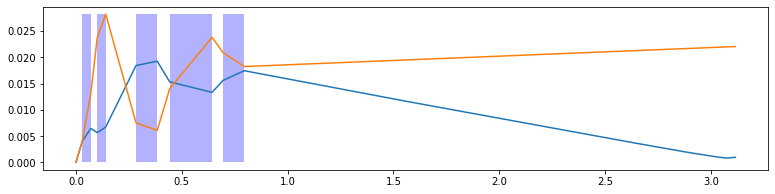

In [3]:
num_particle = 10240

simulator = pyBeamSim.BeamSimulator()
simulator.init_beam(num_particle, 939.294, 1.0, 0.015)
start = time.time()
simulator.set_beamTwiss(0, 0.01, 0.0002,0, 0.01, 0.0002,0, 6.5430429, 0.00005633529, 0, 3, 500, 1)
# simulator.plot_beam()
# simulator.beam_print_to_file("./beam_file/init_beam")
print(time.time()-start ,'s')
simulator.load_Beamline_From_DatFile("F:/git_workspace/Multi-Particle-BeamLine-Simulation/Main_for_simulation/yc_model.dat")
element_names = simulator.get_Beamline_ElementNames()
start = time.time()
envelope = simulator.simulate_and_getEnvelope(False)
print(time.time()-start, 's')
simulator.plot_envelope(envelope)

# 2.1 贝叶斯优化，定义目标函数，可调参数为G1、G2、G3

In [3]:
num_particle = 10240

envelope_animation = []
min_loss = 10000
min_loss_list = []
beam_filename_list = []

def modify_parameters_and_simulate(G1, G2, G3):
    simulator.set_magnet_with_name("Q1", G1)
    simulator.set_magnet_with_name("Q2", G2)
    simulator.set_magnet_with_name("Q3", G3)
    simulator.set_beamTwiss(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 6.5430429, 0.0005633529, 0, 3, 500, 1)
    envelope = simulator.simulate_and_getEnvelope(False)
    return envelope

def obj(args):
    global min_loss
    global min_loss_list
    global envelope_animation
    global beam_filename_list
    G1, G2, G3 = args
    envelope = modify_parameters_and_simulate(G1, G2, G3)
    
    sig_x = simulator.getBeamSigx()
    sig_y = simulator.getBeamSigy()
    loss_ratio = envelope[-1, 3]/num_particle
    
    ans = loss_ratio + (sig_x + sig_y)*10 + abs(sig_x - sig_y)*15
    
    if min_loss > ans:
        min_loss = ans
        envelope_animation.append(envelope)
        filename = "./beam_file/step_%d"%(len(beam_filename_list))
        simulator.beam_print_to_file(filename)
        beam_filename_list.append(filename)
    else:
        envelope_animation.append(envelope_animation[-1])
        beam_filename_list.append(beam_filename_list[-1])
    min_loss_list.append(min_loss)
    return {'loss':ans, 'status': STATUS_OK}

## 2.1.1 记录loss变化，制作包络和束斑变化动画

## 可调范围
G1：0 - 50T/m
G2: -25 - 0 T/m
G3: 0 - 25 T/m

## 搜索空间范围
16% 16% 16%

100%|████████████████████████████████████████████| 200/200 [00:09<00:00, 21.55trial/s, best loss: 0.014936002079201954]
{'G1': 18.264884989765203, 'G2': -10.738778627295455, 'G3': 7.707000975887156}


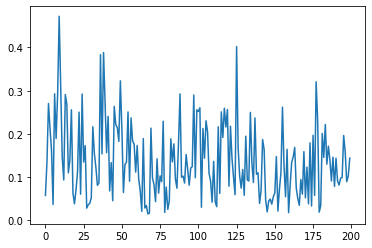

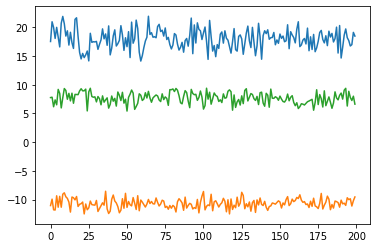

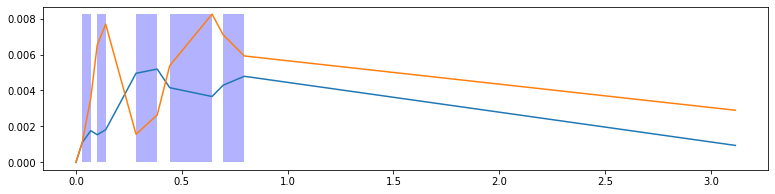

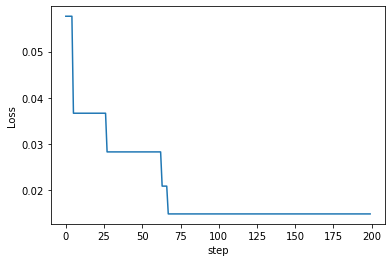

In [20]:
envelope_animation = []
beam_filename_list = []
min_loss_list = []
min_loss = 10000
G_trials = Trials()
best_G = fmin(
    fn=obj,
    space=[hp.uniform('G1', 14, 22), hp.uniform('G2', -12.5, -8.5), hp.uniform('G3', 5.4, 9.4)],
    algo=tpe.suggest,
    max_evals=200,
    trials = G_trials)

print(best_G)
plt.plot(G_trials.losses())

vals = [item['misc']['vals'] for item in G_trials.trials]
G1_list = [item['G1'][0] for item in vals]
G2_list = [item['G2'][0] for item in vals]
G3_list = [item['G3'][0] for item in vals]

plt.figure()
plt.plot(G1_list)
plt.plot(G2_list)
plt.plot(G3_list)
plt.show()

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)
plt.figure()
plt.plot(min_loss_list)
plt.xlabel("step")
plt.ylabel("Loss")
plt.show()

## 2.1.2 定义动画制作的函数

In [17]:
def make_envelope_animation(envelope_file_path, beam_file_path):
    element_types = simulator.get_Beamline_ElementTypes()
    element_lengths = simulator.get_Beamline_ElementLengths()
    position_start = np.array([])
    position_end = np.array([])
    for i in range(element_lengths.shape[0]):
        position_start = np.append(position_start, element_lengths[:i].sum())
        position_end = np.append(position_end, position_start[i] + element_lengths[i])

    fig, ax = plt.subplots(figsize=(13,3))
#     plt.figure(figsize=(13,3))
    # plt.plot(envelope[:,0], envelope[:,1])
    # plt.plot(envelope[:,0], envelope[:,2])
    # max_enve = envelope[:, [1,2]].max().max()
    max_enve = 0.02

    deviceType_list = ["Dipole", "Solenoid", "Quad"]
    for i in range(len(element_types)):
        if element_types[i] in deviceType_list:
            element_start = position_start[i]
            element_end = position_end[i]
            if element_types[i] == "Dipole":
                plt.fill_between([element_start, element_end],0, max_enve,facecolor = 'pink', alpha = 0.9)
            elif element_types[i] == "Solenoid":
                plt.fill_between([element_start, element_end],0, max_enve,facecolor = 'green', alpha = 0.3)
            elif element_types[i] == "Quad":
                plt.fill_between([element_start, element_end],0, max_enve,facecolor = 'blue', alpha = 0.3)   

    def update_envelope(num):
        line_x.set_data(envelope_animation[num][:,0], envelope_animation[num][:,1])
        line_y.set_data(envelope_animation[num][:,0], envelope_animation[num][:,2])
        my_text.set_text("Step %d"%num)
        return line_x
    
    line_x, = ax.plot(envelope_animation[0][:,0], envelope_animation[0][:,1])
    line_y, = ax.plot(envelope_animation[0][:,0], envelope_animation[0][:,2])
    ax.set_ylim(0,0.02)
    my_text = ax.text(2.2, 0.015, " ", fontsize= 25, verticalalignment="top", horizontalalignment="right")
    # 开始制作动画
    ani = animation.FuncAnimation(fig, update_envelope, range(200), interval=100, blit=False)
    ani.save(envelope_file_path, writer='imagemagick', fps=10)
    
    fig, ax = plt.subplots(figsize=(6,6))
  
    def update_beam(num):
        global my_text
        beam_filename = beam_filename_list[num]
        if(num == 0 or beam_filename != beam_filename_list[num-1]):
            ax.clear()
            ax.set_xlim(-0.01, 0.01)
            ax.set_ylim(-0.01, 0.01)
            beam_data = np.loadtxt(beam_filename)
            ax.scatter(beam_data[:,0], beam_data[:,2], s=1)
            my_text = ax.text(0, 0.008, "Step %d"%num, fontsize= 25, verticalalignment="top", horizontalalignment="right")
        my_text.set_text("Step %d"%num)

    ax.set_xlim(-0.01, 0.01)
    ax.set_ylim(-0.01, 0.01)
    beam_filename = beam_filename_list[0]
    beam_data = np.loadtxt(beam_filename)
    ax.scatter(beam_data[:,0], beam_data[:,2], s=1)

    my_text = ax.text(0, 0.008, " ", fontsize= 25, verticalalignment="top", horizontalalignment="right")
    # 开始制作动画
    ani = animation.FuncAnimation(fig, update_beam, range(200), interval=100, blit=False)
    ani.save(beam_file_path, writer='imagemagick', fps=10)

MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


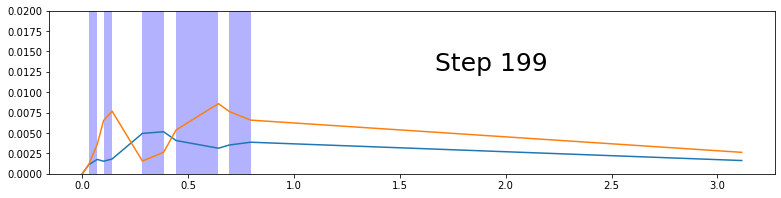

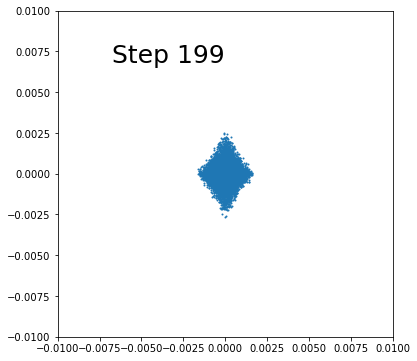

In [18]:
make_envelope_animation('./beam_file_6_6/envlope_Bayes_SigmaObj1.gif', './beam_file/beam_Bayes_SigmaObj1.gif')

## 2.2 更小的搜索空间范围，占可调范围的8%

100%|████████████████████████████████████████████| 200/200 [00:09<00:00, 21.05trial/s, best loss: 0.012378049815506064]
{'G1': 17.746436955605404, 'G2': -10.765431284349306, 'G3': 7.860882312170333}


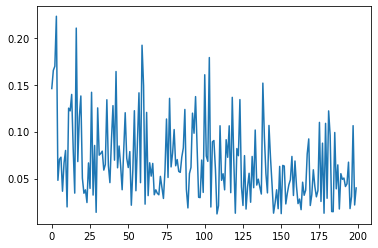

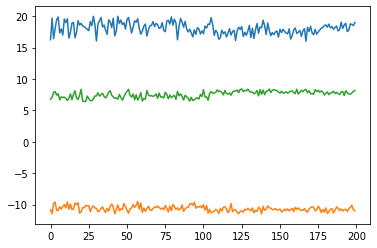

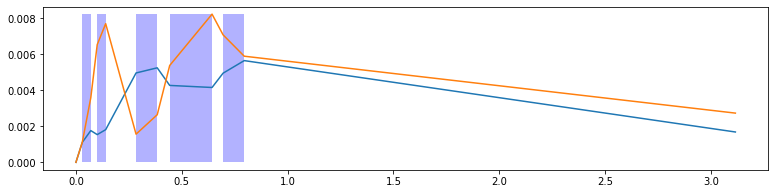

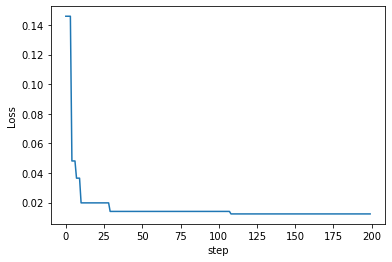

In [21]:
envelope_animation = []
beam_filename_list = []
min_loss_list = []
min_loss = 10000
G_trials = Trials()
best_G = fmin(
    fn=obj,
    space=[hp.uniform('G1', 16, 20), hp.uniform('G2', -11.5, -9.5), hp.uniform('G3', 6.4, 8.4)],
    algo=tpe.suggest,
    max_evals=200,
    trials = G_trials)

print(best_G)
plt.plot(G_trials.losses())

vals = [item['misc']['vals'] for item in G_trials.trials]
G1_list = [item['G1'][0] for item in vals]
G2_list = [item['G2'][0] for item in vals]
G3_list = [item['G3'][0] for item in vals]

plt.figure()
plt.plot(G1_list)
plt.plot(G2_list)
plt.plot(G3_list)
plt.show()

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)
plt.figure()
plt.plot(min_loss_list)
plt.xlabel("step")
plt.ylabel("Loss")
plt.show()

## 2.2.1 多次统计loss随步数的变化

In [5]:
import pandas as pd
import seaborn as sns

100%|████████████████████████████████████████████| 200/200 [00:07<00:00, 27.17trial/s, best loss: 0.013493767562562528]


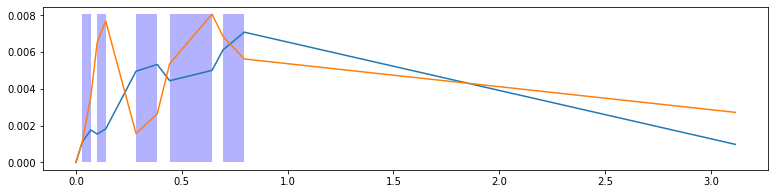

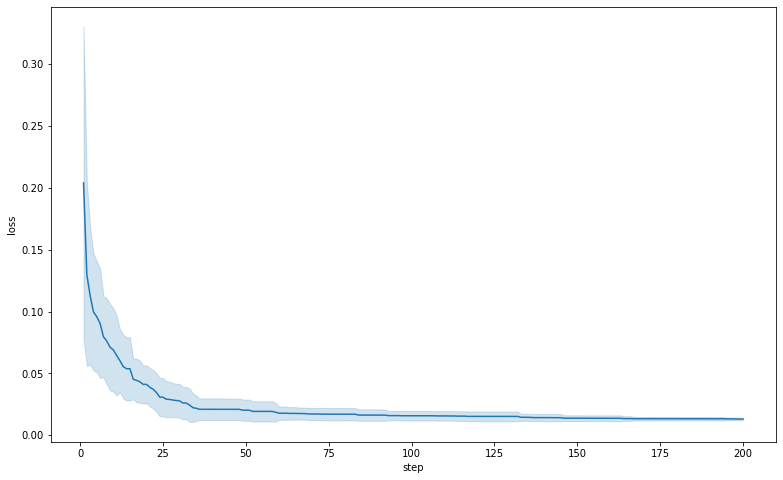

In [9]:
loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(20):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj,
        space=[hp.uniform('G1', 16, 20), hp.uniform('G2', -12.5, -8.5), hp.uniform('G3', 6.4, 10.4)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)

plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

100%|████████████████████████████████████████████| 200/200 [00:09<00:00, 21.48trial/s, best loss: 0.013569101548717481]


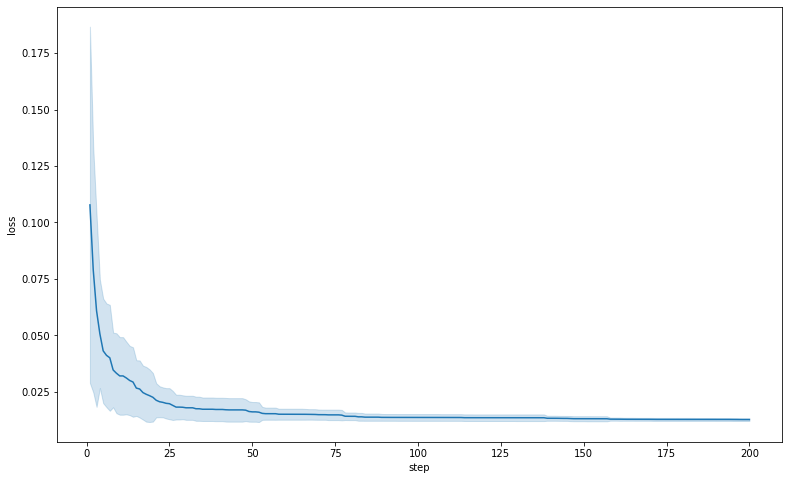

In [10]:
loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(20):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj,
        space=[hp.uniform('G1', 16, 20), hp.uniform('G2', -11.5, -9.5), hp.uniform('G3', 7.4, 9.4)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

# 2.3 减小参数个数，只优化G2、G3

100%|████████████████████████████████████████████| 200/200 [00:08<00:00, 23.98trial/s, best loss: 0.011890779349254728]


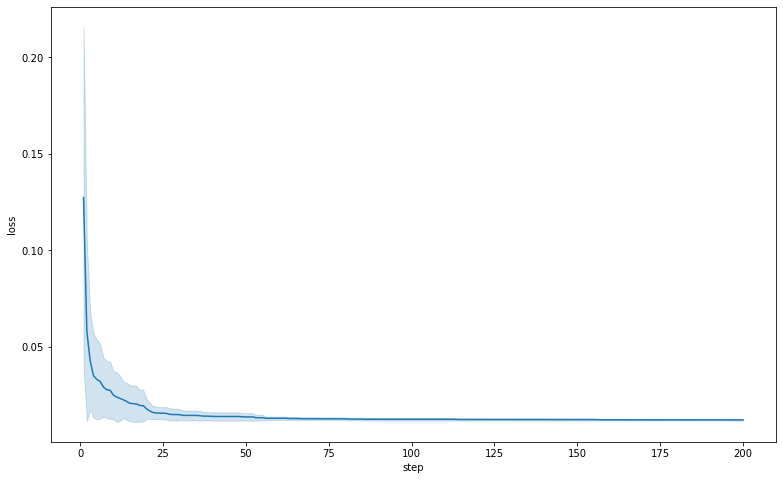

In [12]:
def obj_G1G2(args):
    global min_loss
    global min_loss_list
    global envelope_animation
    global beam_filename_list
    G1 = 17.531148
    G2, G3 = args
    envelope = modify_parameters_and_simulate(G1, G2, G3)
    
    sig_x = simulator.getBeamSigx()
    sig_y = simulator.getBeamSigy()
    loss_ratio = envelope[-1, 3]/num_particle
    
    ans = loss_ratio + (sig_x + sig_y)*10 + abs(sig_x - sig_y)*15
    
    if min_loss > ans:
        min_loss = ans
        envelope_animation.append(envelope)
        filename = "./beam_file/step_%d"%(len(beam_filename_list))
        simulator.beam_print_to_file(filename)
        beam_filename_list.append(filename)
    else:
        envelope_animation.append(envelope_animation[-1])
        beam_filename_list.append(beam_filename_list[-1])
    min_loss_list.append(min_loss)
    return {'loss':ans, 'status': STATUS_OK}

loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(20):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj_G1G2,
        space=[hp.uniform('G2', -11.5, -9.5), hp.uniform('G3', 7.4, 9.4)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

# 2.4 进一步缩小参数范围

100%|████████████████████████████████████████████| 200/200 [00:08<00:00, 24.15trial/s, best loss: 0.012343966310269202]


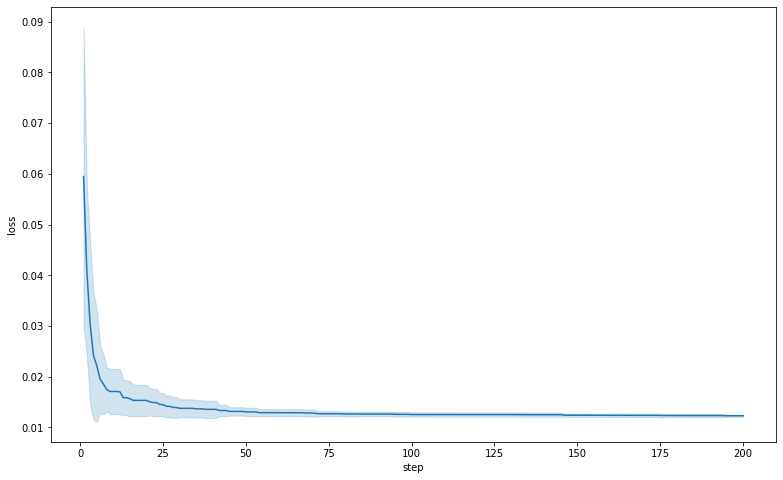

In [11]:
loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(20):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj,
        space=[hp.uniform('G1', 17, 18), hp.uniform('G2', -11.5, -10.5), hp.uniform('G3', 8.5, 9.5)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]
        
plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

# 2.5 减少优化目标的个数

100%|████████████████████████████████████████████| 200/200 [00:07<00:00, 25.46trial/s, best loss: 0.011413913903926496]


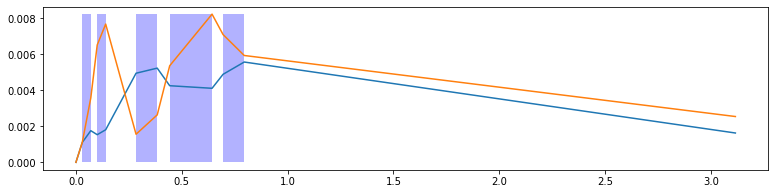

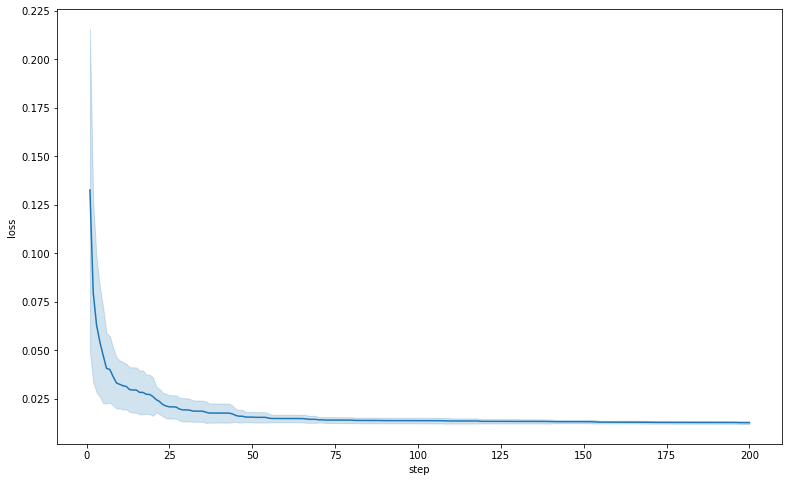

In [7]:
def obj_G1G2(args):
    global min_loss
    global min_loss_list
    global envelope_animation
    global beam_filename_list
    G1, G2, G3 = args
    envelope = modify_parameters_and_simulate(G1, G2, G3)
    
    sig_x = simulator.getBeamSigx()
    sig_y = simulator.getBeamSigy()
    loss_ratio = envelope[-1, 3]/num_particle
    
#     ans = loss_ratio + (sig_x + sig_y)*10 + abs(sig_x - sig_y)*15
    ans = loss_ratio
    
    if min_loss > ans:
        min_loss = ans
        envelope_animation.append(envelope)
        filename = "./beam_file/step_%d"%(len(beam_filename_list))
        simulator.beam_print_to_file(filename)
        beam_filename_list.append(filename)
    else:
        envelope_animation.append(envelope_animation[-1])
        beam_filename_list.append(beam_filename_list[-1])
    min_loss_list.append(min_loss)
    return {'loss':ans, 'status': STATUS_OK}

loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(20):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj,
        space=[hp.uniform('G1', 16, 20), hp.uniform('G2', -11.5, -9.5), hp.uniform('G3', 7.4, 9.4)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)

plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

100%|█████████████████████████████████████████████| 200/200 [00:09<00:00, 21.99trial/s, best loss: 0.06983929991715421]


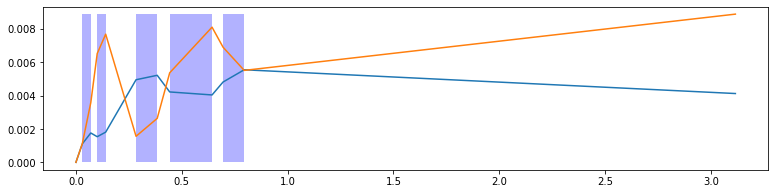

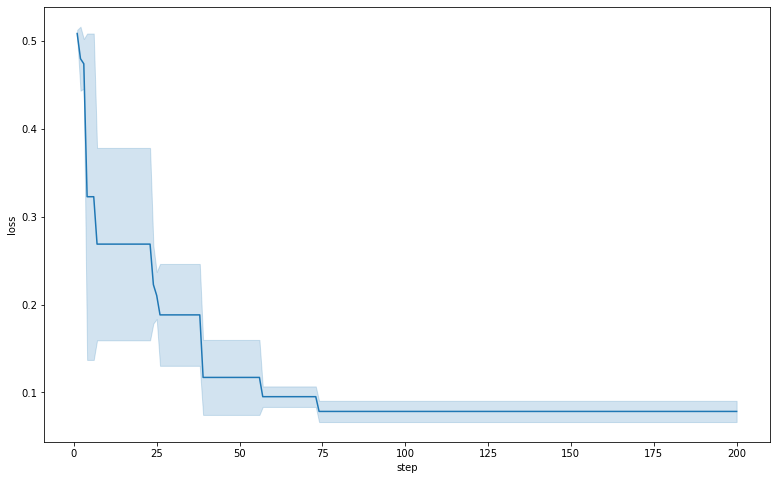

In [8]:
def obj_G1G2(args):
    global min_loss
    global min_loss_list
    global envelope_animation
    global beam_filename_list
    G1, G2, G3 = args
    envelope = modify_parameters_and_simulate(G1, G2, G3)
    
    sig_x = simulator.getBeamSigx()
    sig_y = simulator.getBeamSigy()
    loss_ratio = envelope[-1, 3]/num_particle
    
#     ans = loss_ratio + (sig_x + sig_y)*10 + abs(sig_x - sig_y)*15
    ans = loss_ratio
    
    if min_loss > ans:
        min_loss = ans
        envelope_animation.append(envelope)
        filename = "./beam_file/step_%d"%(len(beam_filename_list))
        simulator.beam_print_to_file(filename)
        beam_filename_list.append(filename)
    else:
        envelope_animation.append(envelope_animation[-1])
        beam_filename_list.append(beam_filename_list[-1])
    min_loss_list.append(min_loss)
    return {'loss':ans, 'status': STATUS_OK}

loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(2):
#     envelope_animation = []
#     beam_filename_list = []
    min_loss_list = []
    min_loss = 10000
    G_trials = Trials()
    best_G = fmin(
        fn=obj,
        space=[hp.uniform('G1', 0, 25), hp.uniform('G2', -25, 0), hp.uniform('G3', 0, 25)],
        algo=tpe.suggest,
        max_evals=200,
        trials = G_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

envelope = modify_parameters_and_simulate(best_G['G1'], best_G['G2'], best_G['G3'])
simulator.plot_envelope(envelope)

plt.figure(figsize=(13, 8))
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

# 4. 目标复杂程度的影响

100%|██████████████████████████████████████████████| 30/30 [00:00<00:00, 999.99trial/s, best loss: 0.00238217623162444]


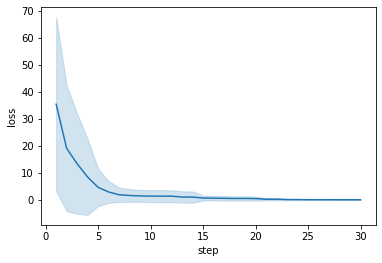

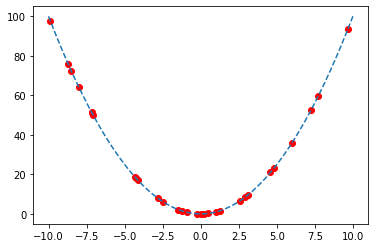

In [65]:
def obj1(args):
    global min_loss, min_loss_list
    x, = args
    loss = (x)**2
    if loss < min_loss:
        min_loss = loss
        min_loss_list.append(min_loss)
    else:
        min_loss_list.append(min_loss)
    return loss

loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(30):
    min_loss_list = []
    min_loss = 10000
    x_trials = Trials()
    best_x = fmin(fn=obj1, space=[hp.uniform('x', -10, 10)], algo=tpe.suggest, max_evals=30, trials = x_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

plt.figure()
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()


x_linspace = np.linspace(-10, 10, 500)
y_standard = [(x)**2 for x in x_linspace]
plt.figure()
plt.plot(x_linspace, y_standard, '--')

x_list = [item['misc']['vals']['x'][0] for item in x_trials.trials]
loss = [item['result']['loss'] for item in x_trials.trials]
plt.scatter(x_list, loss, marker='o', c='r')
plt.show()

100%|█████████████████████████████████████████████| 200/200 [00:00<00:00, 453.60trial/s, best loss: -9.390221919937753]


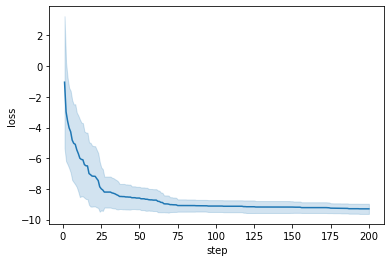

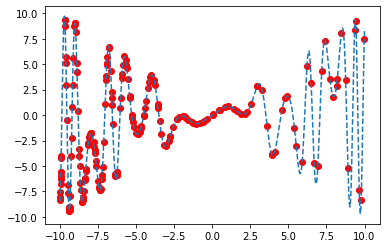

In [67]:
min_loss_list = []
min_loss = 10000

def obj2(args):
    global min_loss, min_loss_list
    x, = args
    loss = np.sin(x*np.sin(x)-5)*x
    if loss < min_loss:
        min_loss = loss
        min_loss_list.append(min_loss)
    else:
        min_loss_list.append(min_loss)
    return loss

loss_dataframe = pd.DataFrame(columns=['step','loss'])
for i in range(30):
    min_loss_list = []
    min_loss = 10000
    x_trials = Trials()
    best_x = fmin(fn=obj2, space=[hp.uniform('x', -10, 10)], algo=tpe.suggest, max_evals=200, trials = x_trials)
    for ind in range(len(min_loss_list)):
        loss_dataframe.loc[len(loss_dataframe)] = [ind+1, min_loss_list[ind]]

plt.figure()
sns.lineplot(data=loss_dataframe, x="step", y="loss", ci="sd")
plt.show()

x_linspace = np.linspace(-10, 10, 500)
y_standard = [np.sin(x*np.sin(x)-5)*x for x in x_linspace]
plt.figure()
plt.plot(x_linspace, y_standard, '--')

x_list = [item['misc']['vals']['x'][0] for item in x_trials.trials]
loss = [item['result']['loss'] for item in x_trials.trials]
plt.scatter(x_list, loss, marker='o', c='r')
plt.show()